# new head bar

# PILOT: Processing of Raw Calcium Cortical Data into dFF tiff Stacks

In [1]:
"""install the packages to run this code"""
#%pip install matplotlib tifffile scipy tqdm pybaselines opencv-python imagecodecs pickle #plotly #need to do this through conda install

'install the packages to run this code'

## Step 1: importing the proper libraries

note: all packaged are compatible with Python 3.12 as of 2024, Feb 22

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import cv2
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.signal import cheby1, filtfilt, find_peaks, peak_widths
import scipy
from tqdm import tqdm
%matplotlib inline
import plotly.express as px
import imagecodecs
from matplotlib.animation import FuncAnimation
import pickle

from preprocessing_functions import (load_frames, 
                                        interactive_plot, 
                                        plot_frame, 
                                        temporal_mean, 
                                        remove_dark_frames, 
                                        extract_artifacts, 
                                        interpolate, 
                                        dff, 
                                        smoothing, 
                                        save_tiff,
                                        load_txt,
                                        extract_txt_flashes,
                                        load_masks, 
                                        avg_trials,
                                        extract_v1,
                                        animate_figure
)

## Step 2: importing and exporting from the script

### 2A: Manual importing data and paths

Please insert the file path for the tif stack as a 3d array

In [3]:
#session = "443076_m1_stage1_day1" #cageID_mouseID_stage_day

In [4]:
#cohort = "1_first_cohort"

In [5]:
file_path = "X:/Raymond Lab/1_Kai/1_cortical_data/Pilot/new_head"

#### 2A.2: importing txt file

### 2B: Manual Exporting data path

In [6]:
#cageID_mouseID = "443076_m1" #cageID_mouseID
#day = "day1" #what day of the stage they are in

### 2C: autonomous loadings and exporting lines !do not need to manipulate!

#### 2C.1: loading frames in

In [7]:
#common_cortical_path = "X:/Raymond Lab/1_Kai/1_cortical_data/"

In [8]:
tiff_path_full = f"{file_path}/new_head.tif"

In [9]:
frame_number = 500 #please insert frame number to view
frames = load_frames(tiff_path_full); #loading in tif stack, this will take a little while

loading video, please wait...
dimensions are (2434, 128, 128) as a uint16


#### 2C.2: Tiff stack (spatial view videos) export

make sure folders exists: files are organized by common_tiff_path -> stage -> day -> full,single,double -> File_name(cage_mouseid_stage_day_condition)

In [10]:
#common_tiff_path = ""X:/Raymond Lab/1_Kai/3_processed_data/1_tiff_stacks/stage1/"

In [11]:
#tiff_path_full = f"{common_tiff_path}/{day}/{full_frame}/{cageID_mouseID}_stage1_{day}_full_frame.tiff"
#tiff_path_avg = f"{common_tiff_path}/{day}/{avg}/{cageID_mouseID}_stage1_{day}_avg.tiff"

#### 2C.3: Pickle export timeseries array

make sure folders exist: files are organized by common_pickle_path -> stage -> day -> single,double -> ROI -> File_name(cage_mouseid_stage_day_condition)

In [12]:
#common_pickle_path = "X:/Raymond Lab/1_Kai/3_processed_data/2_pickle/stage1/"

In [13]:
pickle_ff = f"{file_path}_ff.pickle"

## Step 3: Plot of Raw Frames and Timecourse

### 3A: Plotting raw frame example, to make sure the tif stack loaded in properly.


Make sure the frames are a 3d array, two figures will be generated, a greyscaled and colormapped. They are technically identical

frame number 500 plotted


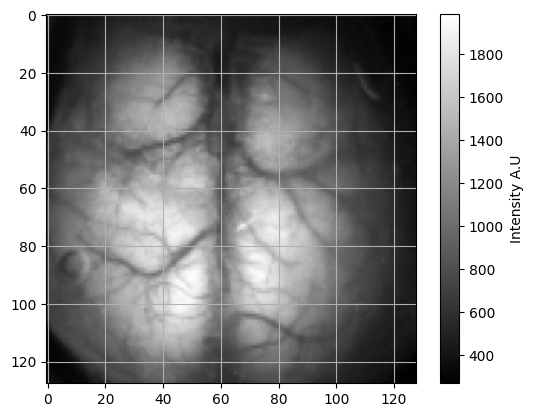

frame number 500 plotted


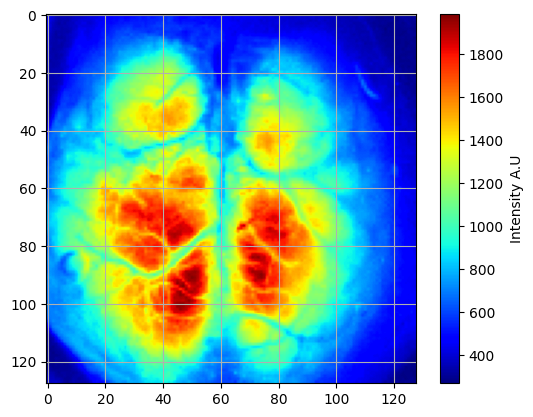

In [14]:
plot_frame(frames, frame_number, cmap = 'grey', color_label = "Intensity A.U")
plot_frame(frames, frame_number, cmap = 'jet', color_label = "Intensity A.U")

### 3B: Plot of the raw signal mean for each frame over the length of the experiment

Mean time course of the raw signal

default 20% threshold is 268.670947265625 Determine if adjustments need to be made


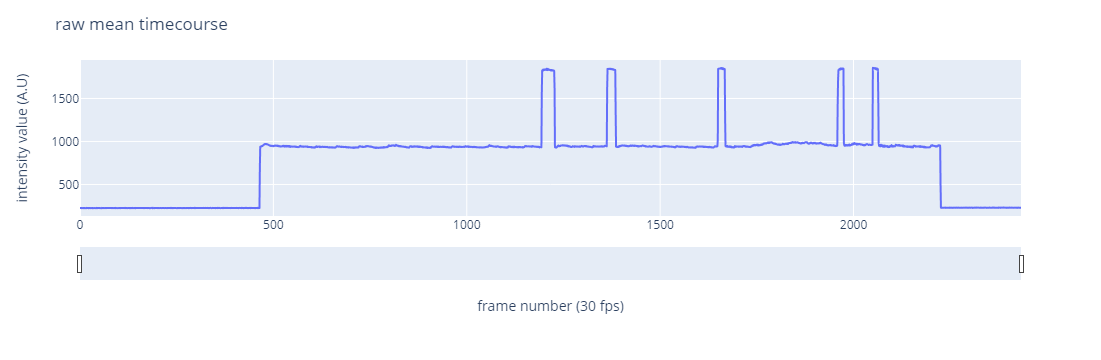

In [15]:
mean_timecourse = temporal_mean(frames);

## Step 4: Mean Timecourse without Darkframes at Start and End

#### 4A: plot of timecourse

#### 4B: number of single and double flashes as well as total number.

threshold determined to be: 302.25481567382815


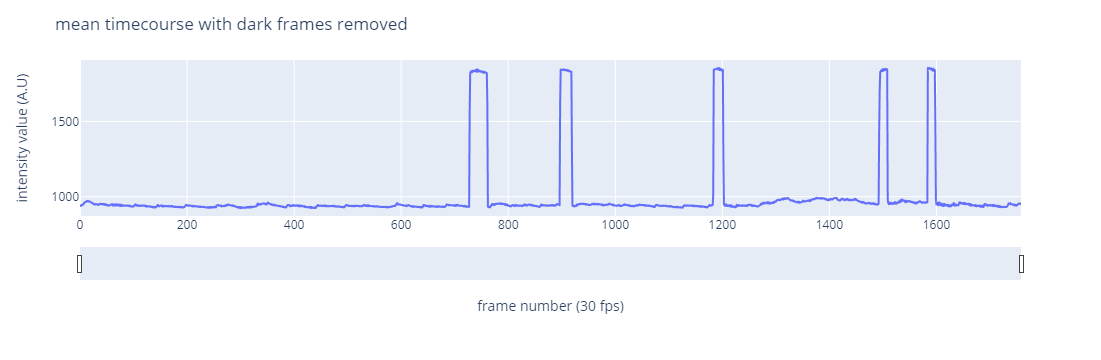

In [16]:
darkf_removed = remove_dark_frames(frames, mean_timecourse, 0.35)
darkf_removed_timecourse, darkf_removed_frames = darkf_removed[0], darkf_removed[1] #first one is the timecourse with no 3d, second is the 3d array

!! If the total does not match the single and double combined, check dataset!!

In [17]:
artifacts = extract_artifacts(darkf_removed_timecourse)
artifact_indices, single_indices = artifacts[0], artifacts[1]

Number of single_flash: 11
Number of total flashes: 11


## Step 5: Artifact Removal and DFF

### 5A: Plot of mean timecourse with artifacts removed


plot is generated with interpolated frames where the artifacts were, approximately 5 frames

interpolating artifact frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.34s/it]


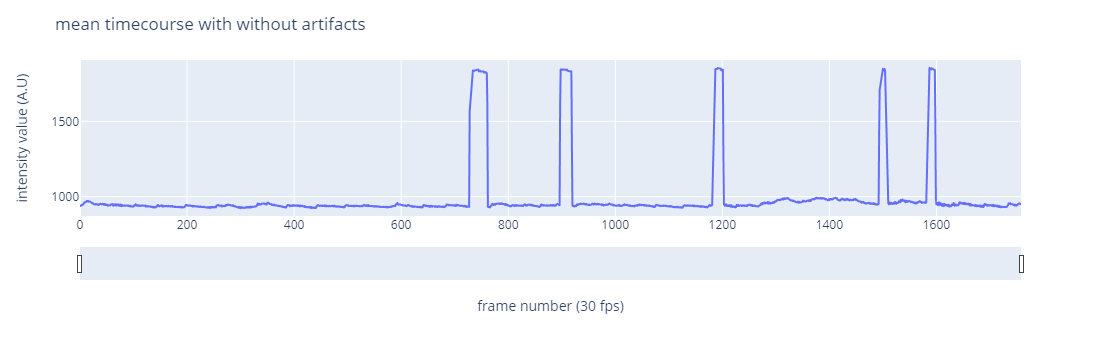

In [18]:
no_artifact_timecourse = interpolate(darkf_removed_frames, artifact_indices, 3)

### 5B: Calculating dff


Dff calculated from the 3d array without artifacts, darkframes removed, and interpolated the space where the artifacts were. Then plotting of the signal with the 10s moving mean before dff is applied. dff is applied using this moving mean onto the signal

In [19]:
dff_array = dff(no_artifact_timecourse, 10, 30);
dff_signal, moving_average = dff_array[0], dff_array[1]

100%|█████████████████████████████████████████████████████████████████████████████| 1759/1759 [00:09<00:00, 192.06it/s]


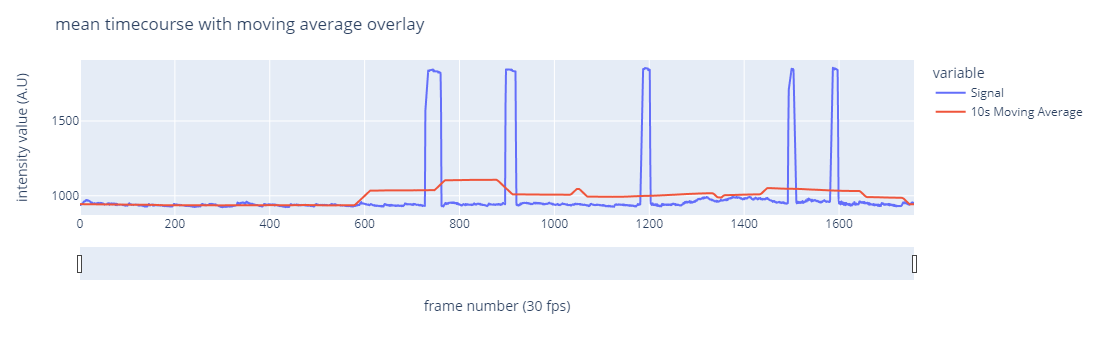

In [20]:
#plotting moving mean and signal
fig = px.line(y = [no_artifact_timecourse.mean(axis=(1,2)), moving_average.mean(axis=(1,2))])
fig.update_layout(
title= "mean timecourse with moving average overlay",
xaxis=dict(title="frame number (30 fps)"),
yaxis=dict(title="intensity value (A.U)"),
xaxis_rangeslider_visible=True,
showlegend=True)

fig.for_each_trace(lambda t: t.update(name="Signal") if "0" in t.name else t.update(name="10s Moving Average"))

fig.show()

#### 5B.1: dff timecourse plot

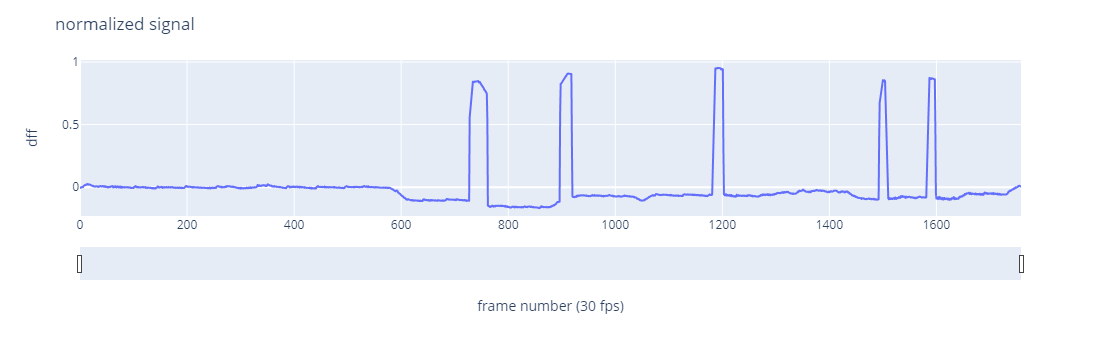

In [21]:
interactive_plot(dff_signal.mean(axis=(1,2)), title_label = "normalized signal", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

## Step 6: Smoothing (spatial and temporal)

### 6A: Spatial smoothing

#### 6A. 1: plot without spatial smoothing showing the requirement for spatial smoothing

frame number 500 plotted


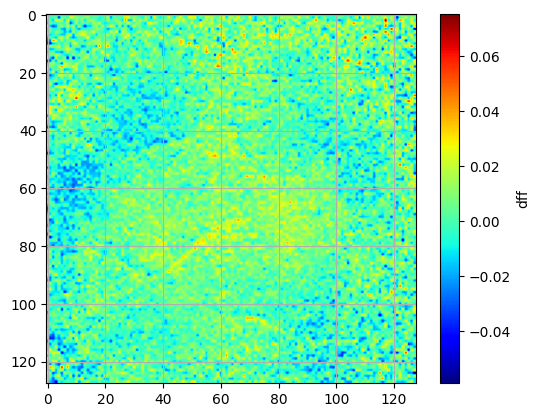

In [22]:
#plot of spatial signal without spatial smoothing
non_smoothed = plot_frame(dff_signal, frame_number, cmap = "jet", color_label = "dff")

#### 6A.2: spatial smoothing applied (gaussian, 3 pixels)

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.43it/s]


frame number 200 plotted


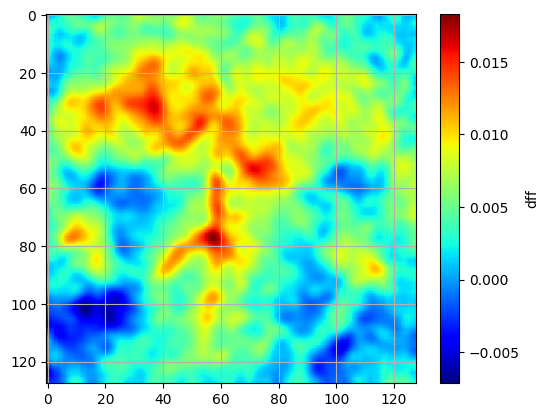

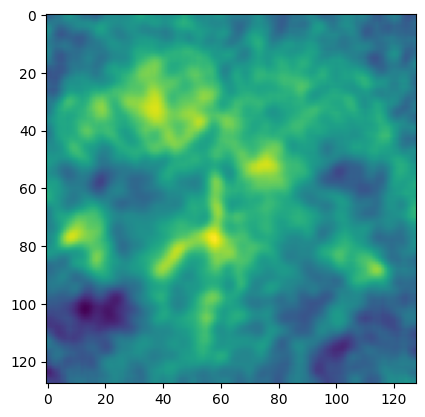

In [23]:
#plot of spatial resolution including spatial smoothing
smoothed_signal = smoothing(dff_signal)
plot_frame(smoothed_signal, 200, cmap = "jet", color_label = "dff")
plt.imshow(smoothed_signal[201])

### 6B: Temporal filtering

dff plot with chebyshev type 1 temporal filtering (high and low bandpass filter)

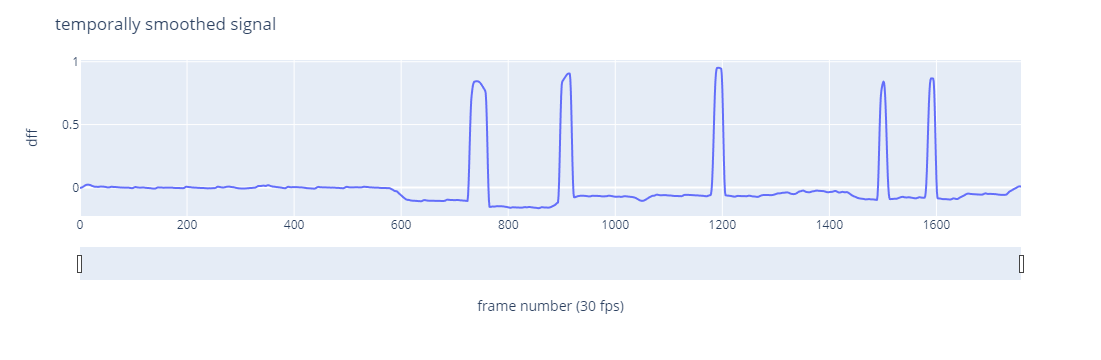

In [24]:
interactive_plot(smoothed_signal.mean(axis=(1,2)), title_label = "temporally smoothed signal", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

## Step 7: ROI plotting

### 7A: ROI full frame

plotting single flash full frame mean

In [25]:
full_roi_single = avg_trials(single_indices, smoothed_signal, 'FALSE', 330)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

In [ ]:
interactive_plot(full_roi_single.mean(axis=(1,2)), title_label = "full frame single average", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

plotting double flash full frame mean

In [ ]:
full_roi_double = avg_trials(double_indices, smoothed_signal, 'TRUE', 330)

In [ ]:
interactive_plot(full_roi_double.mean(axis=(1,2)), title_label = "full frame double average", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

### 7B: V1 ROI

within all of v1 area at the back of the cortex the peak value at 5 frames is taken as the central point and a 15x15 grid is placed around the peak value

plotting single flash just v1 10x10 mean

In [ ]:
v1_area_single = extract_v1(full_roi_single, roi_time = 5, roi_start_x=15, roi_start_y = 85, roi_width=45, roi_height = 45)

In [ ]:
interactive_plot(v1_area_single.mean(axis=(1,2)), title_label = "v1 single average", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

plotting double flash just v1 10x10 mean

In [ ]:
v1_area_double = extract_v1(full_roi_double, roi_time = 5, roi_start_x=15, roi_start_y = 85, roi_width=45, roi_height = 45)

In [ ]:
interactive_plot(v1_area_double.mean(axis=(1,2)), title_label = "v1 double average", xaxis_label = "frame number (30 fps)", yaxis_label = "dff")

## Step 8: Save the 3D array as a TIFF stack

In [ ]:
save_tiff(smoothed_signal, tiff_path_full) # full frame whole session tiff stack
save_tiff(full_roi_single, tiff_path_single) #SINGLE flash averaged response over all trials tiff stack file name to save
save_tiff(full_roi_double, tiff_path_double) #DOUBLE flash averaged response over all trials tiff stack file name to save

print(f"TIFF stack saved at: {file_path}")

### Step 8B: Pickle for uploading into other scripts

In [ ]:
# Now you can use these file paths in your code
with open(pickle_ff, 'wb') as f:
    pickle.dump(v1_area_single, f)

with open(pickle_double_v1, 'wb') as f:
    pickle.dump(v1_area_double, f)

with open(pickle_single_ff, 'wb') as f:
    pickle.dump(full_roi_single, f)

with open(pickle_double_ff, 'wb') as f:
    pickle.dump(full_roi_double, f)

In [ ]:
#single panel
daye = "day11"

folder_path_full = os.path.join(shared_path, daye, "single", "full_frame")
file_path_full = f"{folder_path_full}/443996_m5_stage3_{daye}_single_ff.pickle"
one_day_full = load_one_day_full(file_path_full)
z_score_data_3 = zscore(one_day_full, axis=1)

# Create a figure and subplots
fig, axes = plt.subplots(1, 9, figsize=(20, 10))

# Plot the specific frames
for i, ax in enumerate(axes.flatten()):
    if i < len(frames_to_plot):
        frame_index = frames_to_plot[i]
        image = masked_z_score_single_full[frame_index]
        ax.imshow(image, cmap='RdYlBu')
        fig.set_facecolor('#5D6D7D')  # Set background color to black
        ax.axis('off')
        ax.set_title(f'{frames_to_seconds[i]} s', color='white', fontsize=40)
    else:
        ax.axis('off')  # Hide the axes for unused subplots

plt.tight_layout()
plt.show()

# Mask and animate figures

#### currently not using these, good for visualization and flair

In [ ]:
#masking = load_masks(dff_signal)
#mask, mask_outline = masking[0], masking[1]

#masked_smoothed_signal = smoothed_signal*mask
#masked_full_roi_single = full_roi_single*mask
#masked_full_roi_double = full_roi_double*mask

In [ ]:
#file_path_ = "X:/Raymond Lab/Kaiiiii/processed_data/ #429904_m1_stage2_day2_with_spouts.tiff"
#save_tiff(masked_smoothed_signal, file_path)

#file_path = "X:/Raymond Lab/Kaiiiii/processed_data/ #429904_m1_stage2_day2_with_spouts_avg_single.tiff"
#save_tiff(masked_full_roi_single, file_path)

#file_path = "X:/Raymond Lab/Kaiiiii/processed_data/ #429904_m1_stage2_day2_with_spouts_avg_double.tiff"
#save_tiff(masked_full_roi_double, file_path)

#print(f"TIFF stack saved at: {file_path}")